# 0. Install and Import Dependencies

In [ ]:
! pip list

In [ ]:
! pip install opencv-python matplotlib imageio gdown

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
! nvidia-smi


In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Memory growth must be set before GPUs have been initialized
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Then we limit the memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Now you can run your TensorFlow operations

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [ ]:
import cv2
import tensorflow as tf
from typing import List

def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

In [ ]:
char_to_num.get_vocabulary()

In [ ]:
char_to_num(['n','i','g','g'])

In [ ]:
num_to_char([14,  9,  3, 11])

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = 'data/s1/bbaf4p.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
plt.imshow(frames[20])

In [ ]:
alignments

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(400)
test = data.skip(400)

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(400)
valid= data.skip(400).take(50)
test = data.skip(450).take(50)

In [ ]:
len(test)

In [ ]:
len(test)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

In [ ]:
#imageio.mimsave('./animation.gif', val[0][0], fps=10)

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

In [ ]:
from tensorflow.keras.layers import Reshape

# Model architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


model.add(TimeDistributed(Reshape((-1,))))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [ ]:
model.summary()

In [ ]:
5*17*75

In [ ]:
yhat = model.predict(val[0])

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr


In [ ]:
@tf.keras.utils.register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
'''
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        print('Original:', tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8'))
        print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8'))
        print('~'*100)
'''

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        super().__init__()  # Ensure to call the parent constructor
        self.dataset = dataset.as_numpy_iterator()
        self.data_iterator = None  # Initialize a data iterator

    def on_epoch_begin(self, epoch, logs=None) -> None:
        # Reset the iterator at the beginning of each epoch
        self.data_iterator = self.dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data
        try:
            data = next(self.data_iterator)
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

            # Decode and print original and predicted strings
            original_str = tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8')
            predicted_str = tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8')

            print('Original:', original_str)
            print('Prediction:', predicted_str)
            print('~' * 100)

        except StopIteration:
            print("No more data available for predictions.")


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint','fifty.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=valid, epochs=80, callbacks=[example_callback])

## Save model

In [ ]:
model.save('80_10_10.keras')

# 5. Make a Prediction

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model.keras", custom_objects={'ctc_loss': CTCLoss})

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('data/s1/swiu6p.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# CER and WER

In [ ]:
import tensorflow as tf
import jiwer

# Lists to store ground truth and predicted sentences
ground_truth_list = []
predicted_list = []

# Iterate over the padded test dataset
for batch in test:
    # Get the batch of data and labels
    x_batch, y_batch = batch

    # Predict using the model
    y_pred = model.predict(x_batch)

    # Decode the predicted batch
    decoded_pred = tf.keras.backend.ctc_decode(y_pred, input_length=[75 for _ in range(len(y_pred))], greedy=True)[0][0].numpy()

    # Convert both ground truth and predicted values to strings
    ground_truth_strings = [tf.strings.reduce_join(num_to_char(word)).numpy().decode('utf-8') for word in y_batch]
    predicted_strings = [tf.strings.reduce_join(num_to_char(word)).numpy().decode('utf-8') for word in decoded_pred]

    # Append to lists
    ground_truth_list.extend(ground_truth_strings)
    predicted_list.extend(predicted_strings)


# Compute CER for the entire dataset
cer = jiwer.cer(ground_truth_list, predicted_list)
print(f"Character Error Rate for test dataset: {cer}")

# Compute WER for the entire dataset
wer = jiwer.wer(ground_truth_list, predicted_list)
print(f"Word Error Rate for test dataset: {wer}")


# Loss Graphs

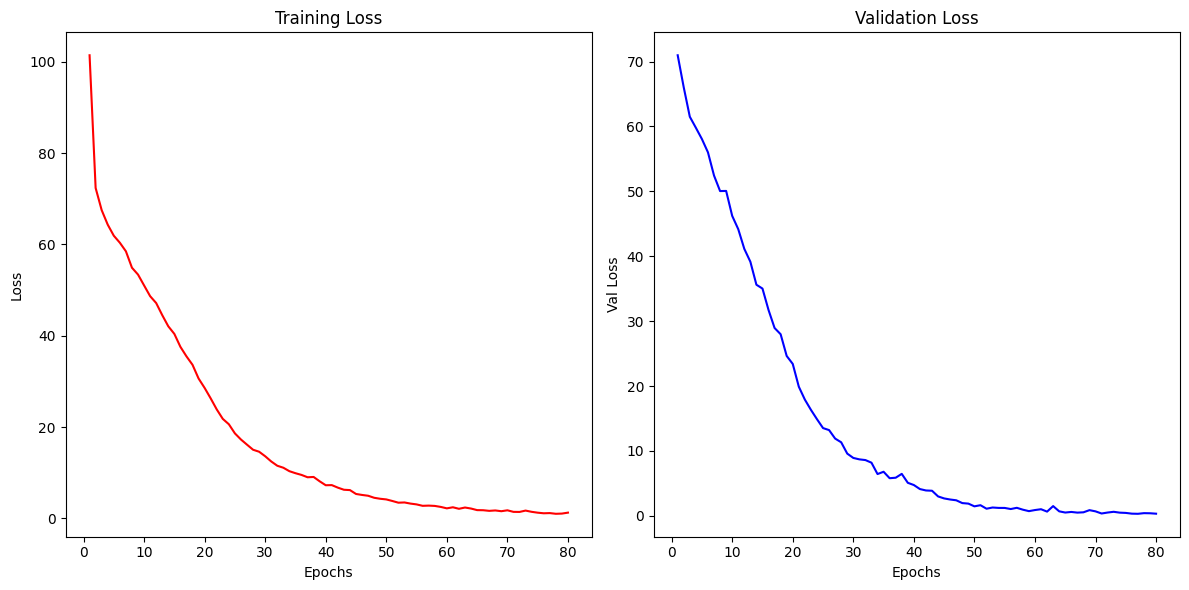

In [ ]:
import matplotlib.pyplot as plt

loss_values = [
    101.4487, 72.3761, 67.5191, 64.3383, 61.9207, 60.3831, 58.5048, 54.9079, 53.4087, 51.0339, 48.6791, 47.1699,
    44.5235, 42.0773, 40.4132, 37.5807, 35.4942, 33.6463, 30.6426, 28.5764, 26.2876, 23.8713, 21.7952, 20.6236,
    18.6210, 17.2756, 16.1465, 15.0383, 14.6011, 13.6129, 12.4684, 11.5329, 11.0969, 10.3373, 9.8979, 9.5228,
    9.0090, 9.0752, 8.1214, 7.2617, 7.2900, 6.7348, 6.2746, 6.1971, 5.3507, 5.1351, 4.9604, 4.5152, 4.2976,
    4.1555, 3.8123, 3.4384, 3.4903, 3.2411, 3.0647, 2.7539, 2.8000, 2.7340, 2.5137, 2.1992, 2.4356, 2.1018,
    2.3807, 2.1558, 1.8112, 1.7893, 1.6514, 1.7389, 1.5735, 1.7709, 1.4300, 1.4131, 1.7116, 1.4398, 1.2502,
    1.1190, 1.1619, 1.0068, 1.0529, 1.2590
]

val_loss_values = [
    70.9637, 66.0087, 61.4914, 59.7941, 58.0526, 55.9951, 52.4257, 50.0377, 50.0571, 46.2146, 44.1661, 41.1321,
    39.1487, 35.6049, 35.0143, 31.7128, 28.9381, 27.9748, 24.6268, 23.4013, 19.8957, 17.9036, 16.3288, 14.8880,
    13.5173, 13.2070, 11.9014, 11.3259, 9.5831, 8.9175, 8.6965, 8.5880, 8.1840, 6.4338, 6.7868, 5.7928, 5.8686,
    6.4612, 5.0857, 4.7411, 4.1208, 3.9035, 3.8614, 2.9867, 2.6768, 2.5098, 2.3897, 1.9596, 1.8797, 1.4579,
    1.6333, 1.0925, 1.2778, 1.2153, 1.2122, 1.0427, 1.2327, 0.9436, 0.7178, 0.8871, 1.0146, 0.6450, 1.4959,
    0.6885, 0.5028, 0.5939, 0.4915, 0.5384, 0.8710, 0.6837, 0.3548, 0.5042, 0.6169, 0.4860, 0.4450, 0.3309,
    0.3095, 0.4080, 0.3917, 0.3258
]

epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss_values, color='blue')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')

plt.tight_layout()
plt.show()

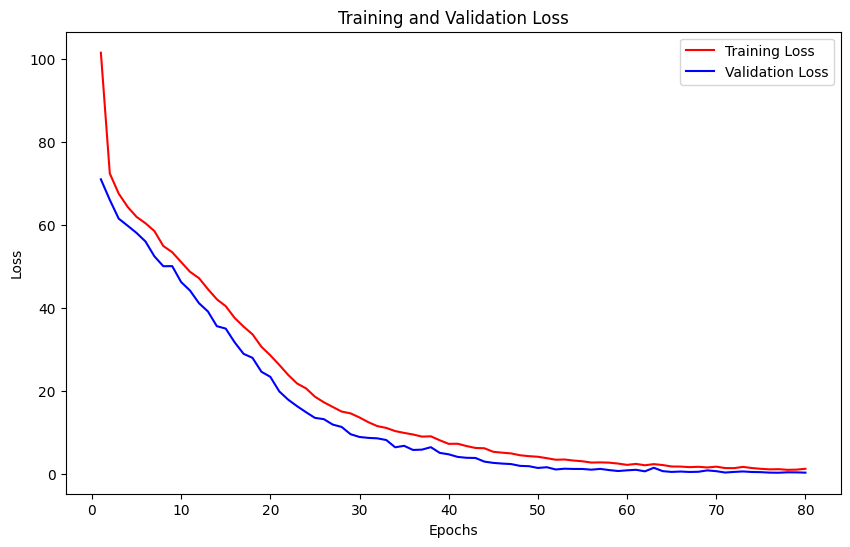

In [ ]:
epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_values, color='red', label='Training Loss')
plt.plot(epochs, val_loss_values, color='blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()